This code is referenced from https://github.com/fpingham/DeepSteg/blob/master/DeepSteganography.ipynb and https://github.com/fpingham/DeepSteg/blob/master/DeepSteganography.ipynb

We are constructing tensorflow models to estimate the encoder and the decoder.

In [1]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *
from skimage import io, transform

%matplotlib inline

Using TensorFlow backend.


In [99]:
IMG_SHAPE = (256, 256)
def load_data(num_images_per_class_train, num_images_test):
    X_train = []
    X_test = []
    TRAIN_DIR = os.path.join("optimization-ii-project-3")
    TEST_DIR = os.path.join("optimization-ii-project-3")
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c)
        if os.path.isdir(c_dir):
            c_imgs = os.listdir(c_dir)
            random.shuffle(c_imgs)
            num_images= num_images_per_class_train
            for img_name_i in c_imgs[0:num_images]:
                img_i = io.imread(os.path.join(c_dir, img_name_i))
                img_i=img_i.astype(np.float)      
#                 print(img_i.shape)          
                X_train.append(img_i)
            for img_name_i in c_imgs[num_images:num_images+2]:
                img_i = io.imread(os.path.join(c_dir, img_name_i))
                img_i=img_i.astype(np.float)      
#                 print(img_i.shape)          
                X_test.append(img_i)

    random.shuffle(X_train)
    random.shuffle(X_test)
    return np.array(X_train)/255., np.array(X_test)/255.
X_train_orig, X_test_orig = load_data(10,500)

In [100]:
print(X_train_orig.shape,X_test_orig.shape)

(80, 256, 256, 3) (16, 256, 256, 3)


In [101]:
# S: secret image
input_S = X_train[0:X_train.shape[0] //2]
# C: cover image
input_C = X_train[X_train.shape[0] //2:]

In [98]:
print(input_C.shape)

(40, 256, 256, 3)


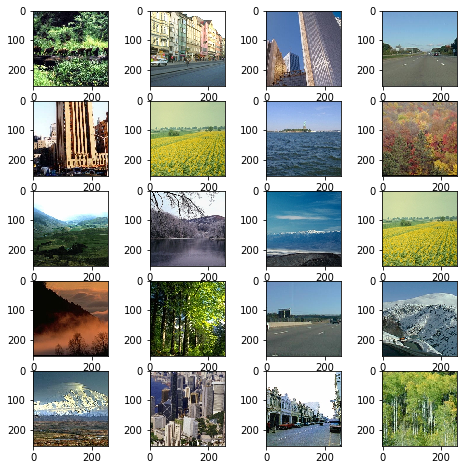

In [102]:
fig = plt.figure(figsize =(8,8))
columns =4
rows =5
for i in range(1,columns*rows +1):
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns ,i)
    plt.imshow(X_train[img_idx])
plt.show()

In [23]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
       # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Network(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [24]:
print(input_C.shape[1:])

(256, 256, 3)


In [25]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

In [26]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [28]:
NB_EPOCHS = 50
BATCH_SIZE = 2

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))




  0%|                                                                                           | 0/20 [00:00<?, ?it/s]c:\users\junli\appdata\local\continuum\anaconda3\envs\computer-vision\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



Epoch 1 | Batch:   0 of 40. Loss AE  252714.22 | Loss Rev  119343.77:   0%|                     | 0/20 [00:26<?, ?it/s]


Epoch 1 | Batch:   0 of 40. Loss AE  252714.22 | Loss Rev  119343.77:   5%|▋            | 1/20 [00:26<08:15, 26.06s/it]


Epoch 1 | Batch:   2 of 40. Loss AE  175689.66 | Loss Rev   84084.73:   5%|▋            | 1/20 [00:45<08:15, 26.06s/it]


Epoch 1 | Batch:   2 of 40. Loss AE  175689.66 | Loss Rev   84084.73:  10%|█▎           | 2/20 [00:45<07:14, 24.16s/it]


Epoch 1 | Batch:   4 of 40. Loss AE 1171771.88 | 

Epoch 2 | Batch:  22 of 40. Loss AE   35103.12 | Loss Rev   21973.21:  55%|██████▌     | 11/20 [08:07<04:06, 27.41s/it]


Epoch 2 | Batch:  22 of 40. Loss AE   35103.12 | Loss Rev   21973.21:  60%|███████▏    | 12/20 [08:07<10:09, 76.18s/it]


Epoch 2 | Batch:  24 of 40. Loss AE   35105.70 | Loss Rev   21705.05:  60%|███████▏    | 12/20 [08:35<10:09, 76.18s/it]


Epoch 2 | Batch:  24 of 40. Loss AE   35105.70 | Loss Rev   21705.05:  65%|███████▊    | 13/20 [08:35<07:11, 61.64s/it]


Epoch 2 | Batch:  26 of 40. Loss AE   34669.22 | Loss Rev   21200.84:  65%|███████▊    | 13/20 [09:02<07:11, 61.64s/it]


Epoch 2 | Batch:  26 of 40. Loss AE   34669.22 | Loss Rev   21200.84:  70%|████████▍   | 14/20 [09:02<05:07, 51.25s/it]


Epoch 2 | Batch:  28 of 40. Loss AE   34215.31 | Loss Rev   20861.51:  70%|████████▍   | 14/20 [09:29<05:07, 51.25s/it]


Epoch 2 | Batch:  28 of 40. Loss AE   34215.31 | Loss Rev   20861.51:  75%|█████████   | 15/20 [09:29<03:40, 44.00s/it]


Epoch 2 | Batch:  30 of 

Epoch 4 | Batch:   6 of 40. Loss AE   27464.05 | Loss Rev   13520.05:  20%|██▌          | 4/20 [01:20<05:23, 20.22s/it]


Epoch 4 | Batch:   8 of 40. Loss AE   26328.66 | Loss Rev   12601.17:  20%|██▌          | 4/20 [01:41<05:23, 20.22s/it]


Epoch 4 | Batch:   8 of 40. Loss AE   26328.66 | Loss Rev   12601.17:  25%|███▎         | 5/20 [01:41<05:03, 20.24s/it]


Epoch 4 | Batch:  10 of 40. Loss AE   25296.85 | Loss Rev   12252.34:  25%|███▎         | 5/20 [02:02<05:03, 20.24s/it]


Epoch 4 | Batch:  10 of 40. Loss AE   25296.85 | Loss Rev   12252.34:  30%|███▉         | 6/20 [02:02<04:46, 20.46s/it]


Epoch 4 | Batch:  12 of 40. Loss AE   24521.15 | Loss Rev   11813.68:  30%|███▉         | 6/20 [02:22<04:46, 20.46s/it]


Epoch 4 | Batch:  12 of 40. Loss AE   24521.15 | Loss Rev   11813.68:  35%|████▌        | 7/20 [02:22<04:25, 20.45s/it]


Epoch 4 | Batch:  14 of 40. Loss AE   24553.87 | Loss Rev   11772.71:  35%|████▌        | 7/20 [02:43<04:25, 20.45s/it]


Epoch 4 | Batch:  14 of 

Epoch 5 | Batch:  32 of 40. Loss AE   15181.37 | Loss Rev    8490.05:  85%|██████████▏ | 17/20 [05:48<01:01, 20.63s/it]


Epoch 5 | Batch:  34 of 40. Loss AE   15316.30 | Loss Rev    8660.25:  85%|██████████▏ | 17/20 [06:09<01:01, 20.63s/it]


Epoch 5 | Batch:  34 of 40. Loss AE   15316.30 | Loss Rev    8660.25:  90%|██████████▊ | 18/20 [06:09<00:41, 20.69s/it]


Epoch 5 | Batch:  36 of 40. Loss AE   15604.08 | Loss Rev    8850.83:  90%|██████████▊ | 18/20 [06:30<00:41, 20.69s/it]


Epoch 5 | Batch:  36 of 40. Loss AE   15604.08 | Loss Rev    8850.83:  95%|███████████▍| 19/20 [06:30<00:20, 20.73s/it]


Epoch 5 | Batch:  38 of 40. Loss AE   15806.50 | Loss Rev    9055.99:  95%|███████████▍| 19/20 [06:50<00:20, 20.73s/it]


Epoch 5 | Batch:  38 of 40. Loss AE   15806.50 | Loss Rev    9055.99: 100%|████████████| 20/20 [06:50<00:00, 20.69s/it]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Epoch 6 | Batch:   0 of 

Epoch 7 | Batch:  18 of 40. Loss AE   11690.53 | Loss Rev    7646.76:  45%|█████▊       | 9/20 [03:13<03:32, 19.33s/it]


Epoch 7 | Batch:  18 of 40. Loss AE   11690.53 | Loss Rev    7646.76:  50%|██████      | 10/20 [03:13<03:13, 19.35s/it]


Epoch 7 | Batch:  20 of 40. Loss AE   11586.44 | Loss Rev    7700.37:  50%|██████      | 10/20 [03:33<03:13, 19.35s/it]


Epoch 7 | Batch:  20 of 40. Loss AE   11586.44 | Loss Rev    7700.37:  55%|██████▌     | 11/20 [03:33<02:56, 19.58s/it]


Epoch 7 | Batch:  22 of 40. Loss AE   11815.11 | Loss Rev    7829.43:  55%|██████▌     | 11/20 [03:55<02:56, 19.58s/it]


Epoch 7 | Batch:  22 of 40. Loss AE   11815.11 | Loss Rev    7829.43:  60%|███████▏    | 12/20 [03:55<02:42, 20.29s/it]


Epoch 7 | Batch:  24 of 40. Loss AE   11522.74 | Loss Rev    7622.63:  60%|███████▏    | 12/20 [04:17<02:42, 20.29s/it]


Epoch 7 | Batch:  24 of 40. Loss AE   11522.74 | Loss Rev    7622.63:  65%|███████▊    | 13/20 [04:17<02:27, 21.00s/it]


Epoch 7 | Batch:  26 of 

Epoch 9 | Batch:   2 of 40. Loss AE   14203.46 | Loss Rev    8739.53:  10%|█▎           | 2/20 [00:38<05:49, 19.42s/it]


Epoch 9 | Batch:   4 of 40. Loss AE   12874.22 | Loss Rev    7620.26:  10%|█▎           | 2/20 [00:58<05:49, 19.42s/it]


Epoch 9 | Batch:   4 of 40. Loss AE   12874.22 | Loss Rev    7620.26:  15%|█▉           | 3/20 [00:58<05:31, 19.52s/it]


Epoch 9 | Batch:   6 of 40. Loss AE   14055.69 | Loss Rev    8680.24:  15%|█▉           | 3/20 [01:18<05:31, 19.52s/it]


Epoch 9 | Batch:   6 of 40. Loss AE   14055.69 | Loss Rev    8680.24:  20%|██▌          | 4/20 [01:18<05:16, 19.76s/it]


Epoch 9 | Batch:   8 of 40. Loss AE   14009.03 | Loss Rev    8927.63:  20%|██▌          | 4/20 [01:38<05:16, 19.76s/it]


Epoch 9 | Batch:   8 of 40. Loss AE   14009.03 | Loss Rev    8927.63:  25%|███▎         | 5/20 [01:38<04:56, 19.79s/it]


Epoch 9 | Batch:  10 of 40. Loss AE   12986.95 | Loss Rev    8023.92:  25%|███▎         | 5/20 [01:59<04:56, 19.79s/it]


Epoch 9 | Batch:  10 of 

Epoch 10 | Batch:  28 of 40. Loss AE   14662.86 | Loss Rev    9835.46:  75%|████████▎  | 15/20 [04:53<01:37, 19.42s/it]


Epoch 10 | Batch:  30 of 40. Loss AE   14276.35 | Loss Rev    9517.34:  75%|████████▎  | 15/20 [05:13<01:37, 19.42s/it]


Epoch 10 | Batch:  30 of 40. Loss AE   14276.35 | Loss Rev    9517.34:  80%|████████▊  | 16/20 [05:13<01:17, 19.41s/it]


Epoch 10 | Batch:  32 of 40. Loss AE   14017.12 | Loss Rev    9383.19:  80%|████████▊  | 16/20 [05:32<01:17, 19.41s/it]


Epoch 10 | Batch:  32 of 40. Loss AE   14017.12 | Loss Rev    9383.19:  85%|█████████▎ | 17/20 [05:32<00:58, 19.39s/it]


Epoch 10 | Batch:  34 of 40. Loss AE   13924.16 | Loss Rev    9249.98:  85%|█████████▎ | 17/20 [05:51<00:58, 19.39s/it]


Epoch 10 | Batch:  34 of 40. Loss AE   13924.16 | Loss Rev    9249.98:  90%|█████████▉ | 18/20 [05:51<00:38, 19.36s/it]


Epoch 10 | Batch:  36 of 40. Loss AE   14100.81 | Loss Rev    9293.95:  90%|█████████▉ | 18/20 [06:11<00:38, 19.36s/it]


Epoch 10 | Batch:  36 of

Epoch 12 | Batch:  14 of 40. Loss AE    9971.60 | Loss Rev    6250.12:  35%|████▏       | 7/20 [02:38<04:18, 19.85s/it]


Epoch 12 | Batch:  14 of 40. Loss AE    9971.60 | Loss Rev    6250.12:  40%|████▊       | 8/20 [02:38<03:57, 19.83s/it]


Epoch 12 | Batch:  16 of 40. Loss AE    9696.57 | Loss Rev    6164.89:  40%|████▊       | 8/20 [02:58<03:57, 19.83s/it]


Epoch 12 | Batch:  16 of 40. Loss AE    9696.57 | Loss Rev    6164.89:  45%|█████▍      | 9/20 [02:58<03:38, 19.89s/it]


Epoch 12 | Batch:  18 of 40. Loss AE    9751.72 | Loss Rev    6107.34:  45%|█████▍      | 9/20 [03:18<03:38, 19.89s/it]


Epoch 12 | Batch:  18 of 40. Loss AE    9751.72 | Loss Rev    6107.34:  50%|█████▌     | 10/20 [03:18<03:19, 19.93s/it]


Epoch 12 | Batch:  20 of 40. Loss AE    9772.80 | Loss Rev    6200.40:  50%|█████▌     | 10/20 [03:38<03:19, 19.93s/it]


Epoch 12 | Batch:  20 of 40. Loss AE    9772.80 | Loss Rev    6200.40:  55%|██████     | 11/20 [03:38<02:59, 19.93s/it]


Epoch 12 | Batch:  22 of

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Epoch 14 | Batch:   0 of 40. Loss AE   14578.97 | Loss Rev   10556.76:   0%|                    | 0/20 [00:19<?, ?it/s]


Epoch 14 | Batch:   0 of 40. Loss AE   14578.97 | Loss Rev   10556.76:   5%|▌           | 1/20 [00:19<06:05, 19.22s/it]


Epoch 14 | Batch:   2 of 40. Loss AE   11799.26 | Loss Rev    8264.11:   5%|▌           | 1/20 [00:38<06:05, 19.22s/it]


Epoch 14 | Batch:   2 of 40. Loss AE   11799.26 | Loss Rev    8264.11:  10%|█▏          | 2/20 [00:38<05:46, 19.23s/it]


Epoch 14 | Batch:   4 of 40. Loss AE   10226.06 | Loss Rev    6775.62:  10%|█▏          | 2/20 [00:57<05:46, 19.23s/it]


Epoch 14 | Batch:   4 of 40. Loss AE   10226.06 | Loss Rev    6775.62:  15%|█▊          | 3/20 [00:57<05:26, 19.23s/it]


Epoch 14 | Batch:   6 of 40. Loss AE    9884.33 | Loss Rev    6458.57:  15%|█▊          | 3/20 [01:16<05:26, 19.23s/it]


Epoch 14 | Batch:   6 of

KeyboardInterrupt: 

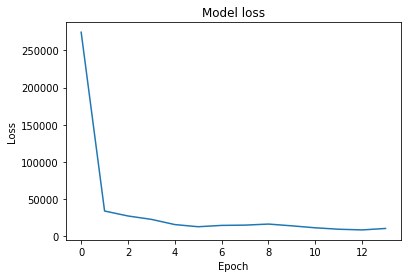

In [29]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [30]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


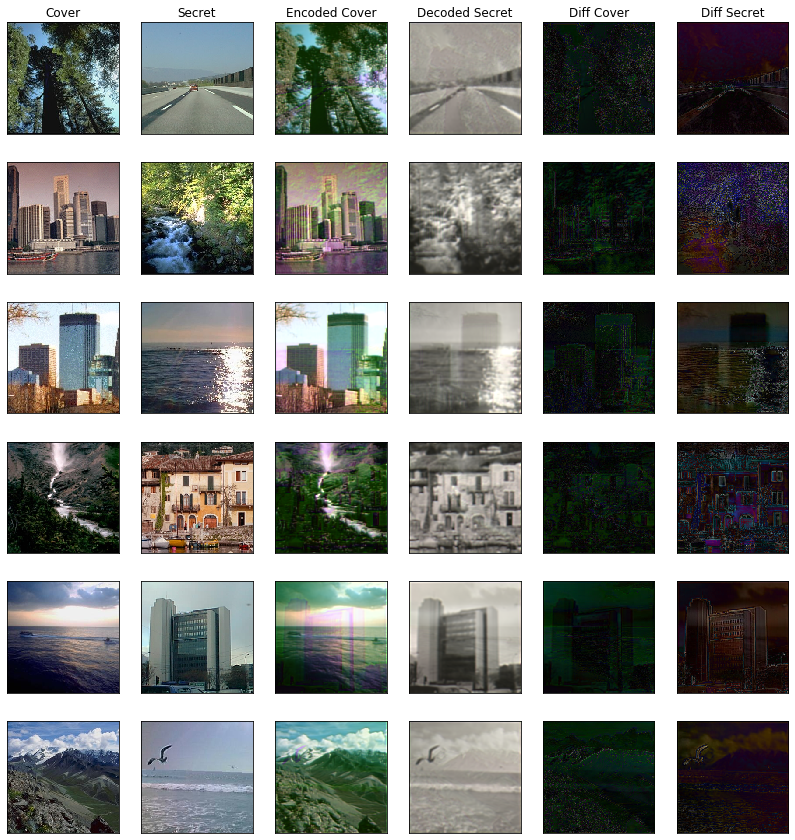

In [32]:

# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 40) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

In [51]:
from skimage.transform import resize

In [80]:
X_testing = []
c_dir = os.path.join("testing-data")
c_imgs = os.listdir(c_dir)[1:]

for img_name_i in c_imgs:
    img_i = io.imread(os.path.join(c_dir, img_name_i))
    image_resized = resize(img_i, (256, 256),anti_aliasing=True)
    X_testing.append(image_resized)
X_testing = np.array(X_testing)

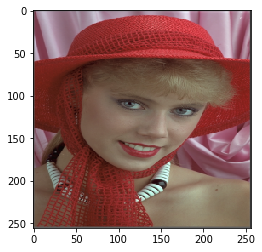

In [81]:
plt.imshow(X_testing[3])

In [88]:
X_testing_a = X_testing

In [90]:
# S: secret image
input_S_test = X_testing_a[0:X_testing_a.shape[0] //2]
# C: cover image
input_C_test = X_testing_a[X_testing_a.shape[0] //2:]

In [91]:
decoded = autoencoder_model.predict([input_S_test, input_C_test])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


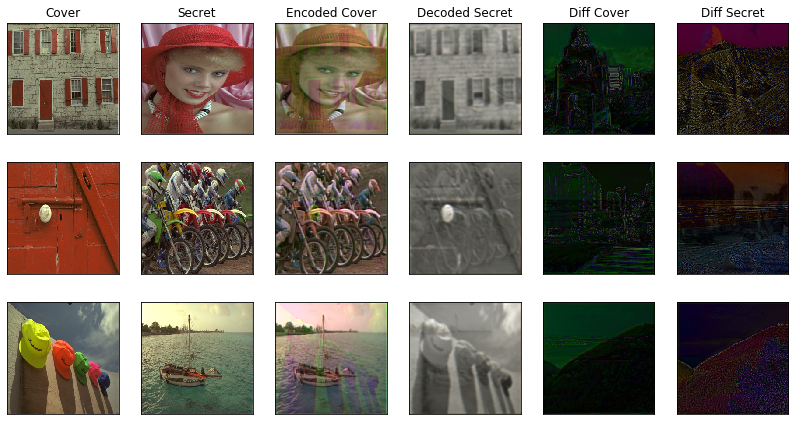

In [94]:
plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 3) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(range(0,3)):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_S_test[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_C_test[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()